In [2]:
import d2l as d2l
import mxnet 
from mxnet import gluon, np
import os
import pandas as pd

In [3]:
d2l.DATA_HUB['ml-100k'] = ('http://files.grouplens.org/datasets/movielens/ml-100k.zip','cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

In [10]:
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

data,num_users, num_items = read_data_ml100k()
print(num_users)
print(num_items)


943
1682


In [11]:
print(data.head(5))

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [13]:
sparsity = 1 - len(data) / (num_users * num_items)
print(sparsity)

0.9369533063577546


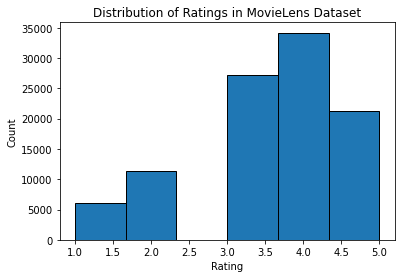

In [19]:
d2l.plt.hist(data['rating'], bins=6, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens Dataset')
d2l.plt.show()

In [21]:
def split_data_ml100k(data, num_users, num_items,split_mode='random', test_ratio=0.1):   
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
                
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
            
            
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
        
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]  
    return train_data, test_data

train_data,test_data = split_data_ml100k(data, num_users, num_items,'random' , test_ratio=0.2)

In [23]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [24]:
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',test_ratio=0.2, batch_size=512):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(data, num_users, num_items, split_mode, test_ratio)
    
    train_u, train_i, train_r, _ = load_data_ml100k(train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(test_data, num_users, num_items, feedback)
    
    train_set = gluon.data.ArrayDataset(np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = gluon.data.ArrayDataset(np.array(test_u), np.array(test_i), np.array(test_r))
    
    train_iter = gluon.data.DataLoader(train_set, shuffle=True, last_batch='rollover',batch_size=batch_size)
    test_iter = gluon.data.DataLoader(test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter